# Predicting User Knowledge Based on Overall Exam Scores and Study Time



## Introduction

In this project, we will use classificationn to predict individuals’ knowledge levels using average exam performance and study time, whose relationships have implications in education. The interplay between study time, exam performance, and overall knowledge of a given subject area is a topic of much debate in the scientific and academic communities, and while most would agree that all factors are related, not everyone agrees on how, despite the consensus that study time positively correlates with exam performance, which indicates superior comprehension. In the process of predicting the knowledge level of an individual, we hope to shed light on the correlations, or lack thereof, between exam performance, study time and overall knowledge.



### Question

**Can we predict the user knowledge level of an individual based on overall exam performance (the averages of exam scores by row) and study time (the averages of study times by row)?**

We will use the “User Knowledge” dataset from the list of recommended datasets.

Our dataset contains six columns:
- `STG` (The degree of study time for goal object materails),
- `SCG` (The degree of repetition number of user for goal object materails)
- `STR` (The degree of study time of user for related objects with goal object)
- `LPR` (The exam performance of user for related objects with goal object)
- `PEG` (The exam performance of user for goal objects)
- `UNS` (The knowledge level of user) 

Each column describes a value (measured by the authors of the dataset) related to the knowledge level of the individual or their performance on a task related to that knowledge (i.e., study time or exam performance). We will use `STG`, `STR`, `LPR`, and `PEG` to predict `UNS`. 


## Method & Results

We will use categorical analysis to classify knowledge level based on values from the STG, STR, LPR and PEG columns. We will split the dataset into a training group and a testing group for investigation and implement five-fold validation into the training group to determine the most accurate value of k for k-nearest neighbor modelling. 

### Loading data & Wrangling and Cleaning the data

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(stringr)
library(dplyr)
set.seed(2021)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

First, we loaded the data from Internet, it is an excel file and already splited into training and testing data set, we just read the training and testing data set into `data_tr` and `data_te`.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
p1f <- tempfile()
download.file(url, p1f, mode="wb")
raw_tr_data <-read_excel(path = p1f, sheet = "Training_Data")
data_tr <- select(raw_tr_data, 1:6)
raw_te_data <-read_excel(path = p1f, sheet = "Test_Data")
data_te <- select(raw_te_data, 1:6)

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



Then, we checked the proportion of the training set, the  training set takes up 64% of the whole data set, this proportion is great

In [3]:
nrow(data_tr)/(nrow(data_te)+nrow(data_tr))

[1] 0.6401985

We also checked whether there is any missing value in the training data set, and found there is no missing value in the training data set

In [4]:
# count the missing value to test sample validity for future computation
sum(is.na(data_tr))

[1] 0

At this step, we transform the Knowledge level (`UNS`) to factor vairables and make the training and testing data set have the same level names

In [5]:
data_tr <- mutate(data_tr, UNS = as_factor(UNS))
levels(data_tr$UNS) <- list(VeryLow = "very_low", Low = "Low", Middle = "Middle", High = "High")
data_te <- mutate(data_te, UNS = as_factor(UNS))
levels(data_te$UNS) <- list(VeryLow = "Very Low", Low = "Low", Middle = "Middle", High = "High")

### Preliminary exploratory data analysis

In this part, we are going to have a quick view of the data, and  exploring some features in the data.

First, we look at the structure of the data, count the number of observations in training set and calculated the mean of each predictor in different knowledge level. We found that there are totally 258 observations in the training set. Only 24 obervations got very low knowledge level. The people got low and middle knowledge level are very close, 83 and 88 sepaprately. 63 observations got high knowlesge level which is ranked in the number 3 the four knowledge levels. We also found that more average study time (`STG` and `STR`) spent seems lead to higher knowledge level. However, the exam performance (`LPR` and `PEG`) seems not very related to the knowledge level at this moment.

In [6]:
head(data_tr)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,VeryLow
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


Table 1: preview of training set of dataset

In [7]:
head(data_te)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,VeryLow
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Table 2: preview of testing set of dataset

In [8]:
nrow(data_tr)
# This shows the number of observations from the training dataset

[1] 258

In [17]:
# the number of observations in each class and the mean value for each column in each class
obs_count <- data_tr %>% 
             group_by(UNS) %>%
             summarise(n_rows = length(UNS), 
                       avg_STG = mean(STG), 
                       avg_STR = mean(STR), 
                       avg_LPR = mean(LPR), 
                       avg_PEG = mean(PEG))
obs_count

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n_rows,avg_STG,avg_STR,avg_LPR,avg_PEG
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
VeryLow,24,0.3057917,0.3662500,0.3587500,0.09083333
Low,83,0.3211446,0.4307229,0.4973494,0.23762651
Middle,88,0.3999773,0.5068182,0.3428409,0.54238636
High,63,0.4216508,0.5016667,0.5012698,0.77253968


Table 3: preview of testing set of dataset

We will mutate the columns to combine `STG` and `STR` (`TST`) and `LPR` and `PEG` (`TEP`) to find the mean of each pair of data to provide 
- ① an average degree of studying time on goal or related subject materials and 
- ② an average degree of exam performance with goal or related subject material. 


The two variables `TST` and `TEP` from mutation and sorting would be used in a k-nearest neighbor model to predict the knowledge level for a certain individual.

In [18]:
# the means of the predictor variables you plan to use in your analysis
# STG, STR, LPR and PEG to predict UNS
# combine STG and STR (TST) and LPR and PEG (TEP) 
mutated_data <- data_tr %>%
                mutate(TEP = (LPR + PEG)/2) %>%
                mutate(TST = (STG + STR)/2)
head(mutated_data)


STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,VeryLow,0.000,0.000
0.08,0.08,0.10,0.24,0.90,High,0.570,0.090
0.06,0.06,0.05,0.25,0.33,Low,0.290,0.055
0.10,0.10,0.15,0.65,0.30,Middle,0.475,0.125
0.08,0.08,0.08,0.98,0.24,Low,0.610,0.080
0.09,0.15,0.40,0.10,0.66,Middle,0.380,0.245


Table 4: preview of mutated training dataset with object data columns

We also calculate the overall mean for each variable

In [19]:
mean_tr <- mutated_data %>%
           select(-SCG, -UNS) %>%
           map_df(mean, na.rm  = TRUE)
mean_tr

STG,STR,LPR,PEG,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.4680039,0.4327132,0.4585388,0.445626,0.4195756


Table 5: view of all means of columns from knowledge

We will represent TST on the x-axis and TEP on the y-axis of a scatter plot, which will colour points by knowledge level, our categorical factor.


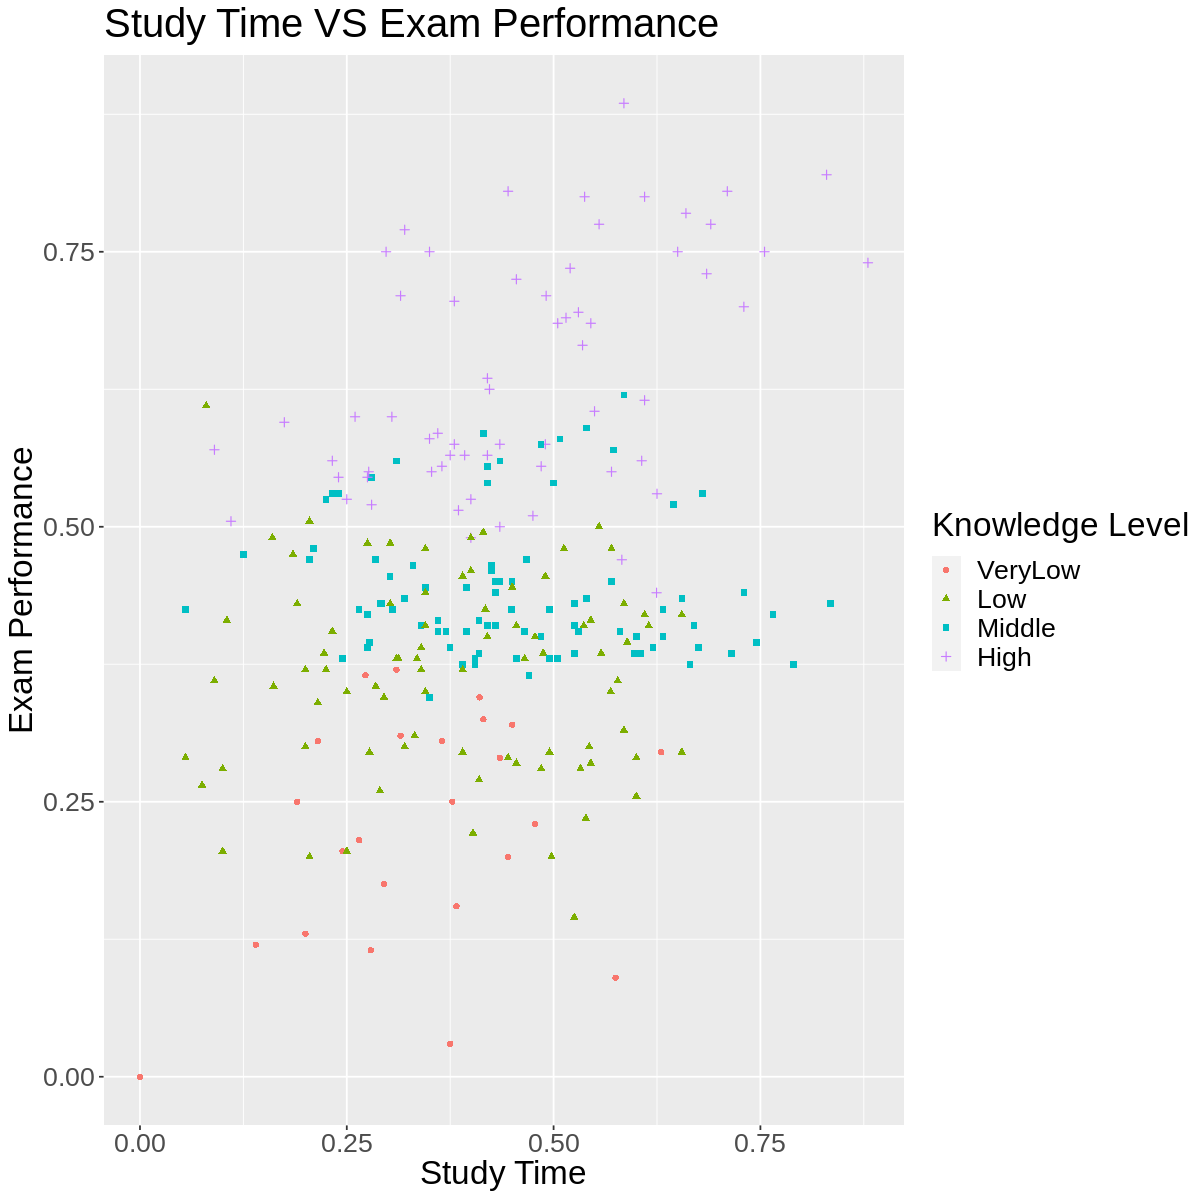

In [20]:
# plot study time VS exam performance
options(repr.plot.width = 10, repr.plot.height = 10)
timeVSperform_plot <- mutated_data %>%
                          ggplot(aes(x=TST, y=TEP))+
                          geom_point(aes(colour= UNS ,shape=UNS))+
                          labs(x="Study Time", 
                               y="Exam Performance", 
                               colour="Knowledge Level", 
                               shape="Knowledge Level")+
                          theme(text = element_text(size=20))+
                          ggtitle("Study Time VS Exam Performance")
timeVSperform_plot


Figure 1: visualization of study time vs exam performance in categories of knowledge level

## Expected outcomes and significance 

We expect a positive correlation between studying time and exam performance, as well as between both variables and knowledge level.


Identifying relationships between studying time, exam performance, and knowledge level would provide insight for educators in terms of whether exams accurately represent students’ knowledge. Studying time would allow students to determine whether their studying methods are effective and allow them to adjust accordingly based on these relationships.


By answering our question, we can expand this project’s applications. Identifying reasons for exam performance or studying time not correlating with knowledge level would encourage educators and students to explore new methods for both: How could students study more effectively, and how could exams be more representative of students’ knowledge? Radically thinking, do exams reflect knowledge level at all?



### Data Analysis

In [21]:
knowledge_recipe <- recipe(UNS~TEP+TST,data = mutated_data)
knowledge_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

In [22]:
set.seed(2021)
knowledge_vfold <- vfold_cv(mutated_data, v = 5, strata = UNS)
gridvals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
knn_tune <-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
      set_mode("classification")
knn_results <- workflow() %>%
      add_recipe(knowledge_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = knowledge_vfold, grid = gridvals) %>%
      collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6008731,5,0.03256396,Model01
1,roc_auc,hand_till,0.7293564,5,0.03117610,Model01
2,accuracy,multiclass,0.6046467,5,0.03062228,Model02
2,roc_auc,hand_till,0.7816749,5,0.03161071,Model02
3,accuracy,multiclass,0.5962723,5,0.04428077,Model03
3,roc_auc,hand_till,0.8269487,5,0.03503340,Model03
4,accuracy,multiclass,0.6001939,5,0.04204964,Model04
4,roc_auc,hand_till,0.8558258,5,0.03294957,Model04
5,accuracy,multiclass,0.6383737,5,0.04607139,Model05


Table 6: all knn neighbor metric columns from tuning the model

[1] 9

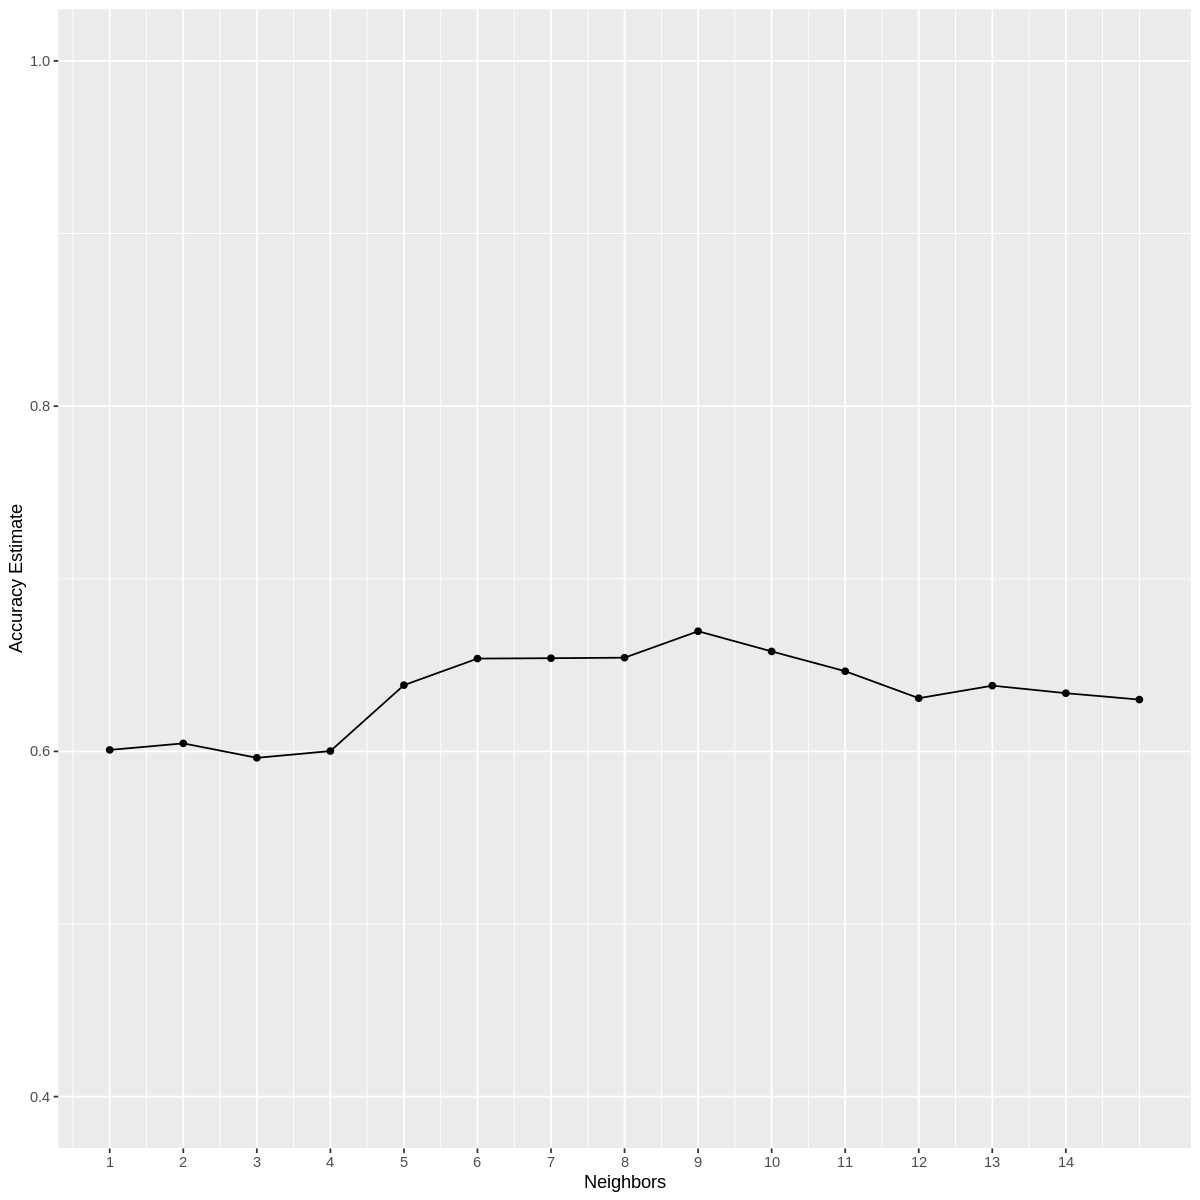

In [23]:
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracies_max <- accuracies %>% arrange(desc(mean)) %>%slice(1) %>% select(neighbors) %>%as.integer()
accuracies_max
accuracy_versus_k

Figure 2: plot of all tuning neighbor's accuracy from training dataset

In [24]:
knowledge_mutated_testing <- data_te %>%
                mutate(TEP = (LPR + PEG)/2) %>%
                mutate(TST = (STG + STR)/2) 
head(knowledge_mutated_testing)
tail(knowledge_mutated_testing)

STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.00,0.10,0.50,0.26,0.05,VeryLow,0.155,0.250
0.05,0.05,0.55,0.60,0.14,Low,0.370,0.300
0.08,0.18,0.63,0.60,0.85,High,0.725,0.355
0.20,0.20,0.68,0.67,0.85,High,0.760,0.440
0.22,0.22,0.90,0.30,0.90,High,0.600,0.560
0.14,0.14,0.70,0.50,0.30,Low,0.400,0.420


STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
0.68,0.61,0.34,0.31,0.23,Low,0.270,0.510
0.90,0.78,0.62,0.32,0.89,High,0.605,0.760
0.85,0.82,0.66,0.83,0.83,High,0.830,0.755
0.56,0.60,0.77,0.13,0.32,Low,0.225,0.665
0.66,0.68,0.81,0.57,0.57,Middle,0.570,0.735
0.68,0.64,0.79,0.97,0.24,Middle,0.605,0.735


Table 7,8 : preview of mutated testing dataset with object data columns

In [25]:
knowledge_best <-nearest_neighbor(weight_func = "rectangular", neighbors = accuracies_max) %>%
        set_engine("kknn") %>%
      set_mode("classification")

In [26]:
knowledge_model <- workflow() %>%
      add_recipe(knowledge_recipe) %>%
      add_model(knowledge_best) %>%
      fit(data = mutated_data)
knowledge_predict <- predict(knowledge_model,new_data = knowledge_mutated_testing) %>% bind_cols(knowledge_mutated_testing)
head(knowledge_predict)
tail(knowledge_predict)


.pred_class,STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
VeryLow,0.00,0.10,0.50,0.26,0.05,VeryLow,0.155,0.250
Low,0.05,0.05,0.55,0.60,0.14,Low,0.370,0.300
High,0.08,0.18,0.63,0.60,0.85,High,0.725,0.355
High,0.20,0.20,0.68,0.67,0.85,High,0.760,0.440
High,0.22,0.22,0.90,0.30,0.90,High,0.600,0.560
Middle,0.14,0.14,0.70,0.50,0.30,Low,0.400,0.420


.pred_class,STG,SCG,STR,LPR,PEG,UNS,TEP,TST
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Low,0.68,0.61,0.34,0.31,0.23,Low,0.270,0.510
High,0.90,0.78,0.62,0.32,0.89,High,0.605,0.760
High,0.85,0.82,0.66,0.83,0.83,High,0.830,0.755
Low,0.56,0.60,0.77,0.13,0.32,Low,0.225,0.665
Middle,0.66,0.68,0.81,0.57,0.57,Middle,0.570,0.735
High,0.68,0.64,0.79,0.97,0.24,Middle,0.605,0.735


Table 9,10: preview of predicted testing dataset with prediction columns

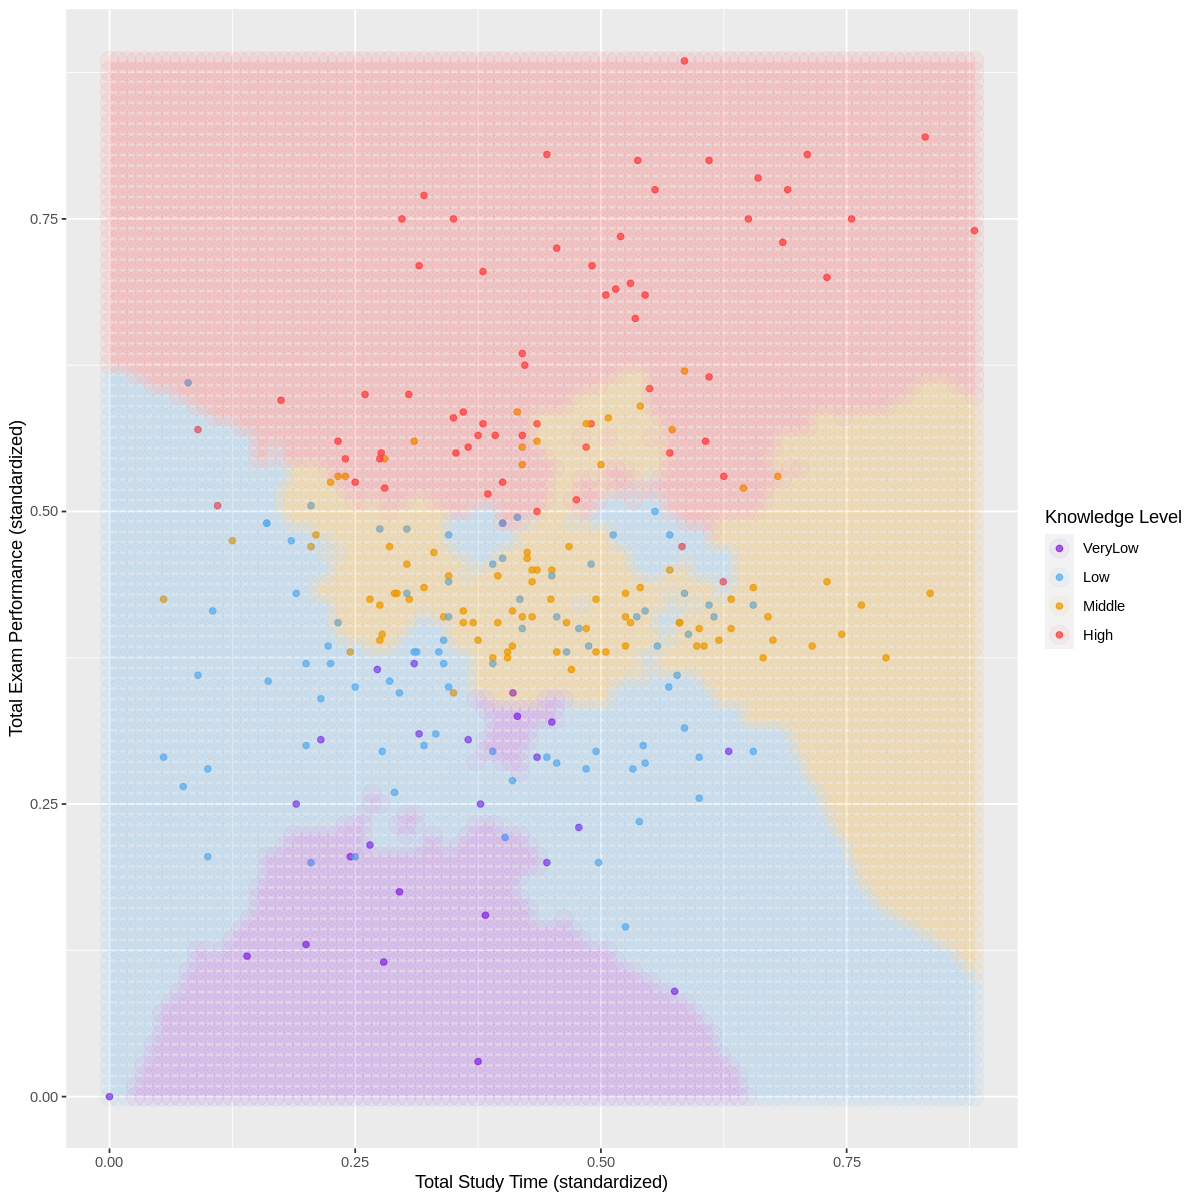

In [27]:
# Code Copied and Modified from Textbook reading 5.8 of "Data Science: A First Introduction", 2021 by Timbers T. , Campbell T. and Lee M.
# create the grid of area/smoothness vals, and arrange in a data frame
x_grid <- seq(min(mutated_data$TST), 
                max(mutated_data$TST), 
                length.out = 100)
y_grid <- seq(min(mutated_data$TEP), 
                max(mutated_data$TEP), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(TST = x_grid, 
                                TEP = y_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knowledge_model, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(UNS = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = mutated_data, 
             mapping = aes(x = TST, 
                           y = TEP, 
                           color = UNS), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = TST, 
                           y = TEP, 
                           color = UNS), 
             alpha = 0.06, 
             size = 5) +
  labs(color = "Knowledge Level", 
       x = "Total Study Time (standardized)", 
       y = "Total Exam Performance (standardized)") +
  scale_color_manual(labels = c("VeryLow", "Low", "Middle","High"), 
                     values = c("blueviolet", "steelblue2", "orange2", "brown1"))

wkflw_plot

Figure 3: colored prediction map visualizations of TST vs TEP with UNS

In [28]:
knowledge_prediction_accuracy<- knowledge_predict %>% metrics(truth = UNS, estimate = .pred_class)
knowledge_matrix <- knowledge_predict %>% conf_mat(truth = UNS, estimate = .pred_class)
knowledge_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6965517
kap,multiclass,0.5898952


Table 10: accuracy measurement of model for testing dataset

In [29]:
knowledge_matrix

          Truth
Prediction VeryLow Low Middle High
   VeryLow      21   3      0    0
   Low           5  28      7    0
   Middle        0  14     15    2
   High          0   1     12   37

## Discussion 


Based on our analysis of the User Knowledge dataset from the UCI Machine Learning Repository, we found that we could use K-NN classification predict the knowledge level of users based on their overall test performance and study time with 70% accuracy — a fairly reasonable accuracy in looking at the applications of this type of model (given the subjective nature of our response variable, “user knowledge”), showing a significant relationship between our predictor and responding variables. 

These findings were consistent with our hypothesis, as we predicted that we would find a positive correlation between exam performance, study time and overall knowledge level. Our classification model and visualizations support this hypothesis. 

The results of this analysis have implications in education, with clear relevance to policy makers, educators and students alike. Given that our analysis shows  a fairly strong relationship between the variables in question in this analysis and our model’s relatively high accuracy, this suggests a way for both students and educators alike to predict their knowledge level on a topic based on exam performance and study time. 

Investigating this research question —  as with most analyses and investigations —  brings up several other questions that are relevant to our initial problem. These include:  How can students more effectively improve their knowledge level on a given topic by optimizing study time? What other variables are key predictors of knowledge level on a topic? What study tools should educators emphasize in order to ensure the long-term learning of students? As well as many more which have the potential to influence the academic community. 


## References

Kesänen, Jukka, et al. *Knowledge Tests in Patient Education: A Systematic Review*, Wiley Online Library, John Wiley & Sons, Ltd, 21 Nov. 2013, https://onlinelibrary.wiley.com/doi/10.1111/nhs.12097. 

Sireci, Stephen G. *NCME Presidential Address 2020: Valuing Educational Measurement*, Wiley Online Library, National Council on Measurement in Education, 4 Jan. 2020, https://onlinelibrary.wiley.com/doi/10.1111/emip.12415. 

H. T. Kahraman, Sagiroglu, S., Colak, I., *Developing intuitive knowledge classifier and modeling of users' domain dependent data in web*, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.
